<a href="https://colab.research.google.com/github/fcolombo7/AN2DL-2020/blob/main/Multiclass_Segmentation_ggg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os

# os.environ["CUDA_VISIBLE_DEVICES"]="-1" 
import tensorflow as tf
import numpy as np

# Set the seed for random operations. 
# This let our experiments to be reproducible. 
SEED = 1234
tf.random.set_seed(SEED)
VALIDATION_SPLIT = 0.2

In [3]:
cwd = os.getcwd()

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
from zipfile import ZipFile
# Create a ZipFile Object and load sample.zip in it
with ZipFile('./drive/MyDrive/ANN_project2/dataset.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

In [6]:
!ls /content/Development_Dataset/Training/Bipbip/Haricot/Images/

Bipbip_haricot_im_00321.jpg  Bipbip_haricot_im_05041.jpg
Bipbip_haricot_im_00391.jpg  Bipbip_haricot_im_05111.jpg
Bipbip_haricot_im_00451.jpg  Bipbip_haricot_im_05141.jpg
Bipbip_haricot_im_00511.jpg  Bipbip_haricot_im_05231.jpg
Bipbip_haricot_im_00651.jpg  Bipbip_haricot_im_05301.jpg
Bipbip_haricot_im_00801.jpg  Bipbip_haricot_im_05351.jpg
Bipbip_haricot_im_00871.jpg  Bipbip_haricot_im_05361.jpg
Bipbip_haricot_im_01021.jpg  Bipbip_haricot_im_05411.jpg
Bipbip_haricot_im_01091.jpg  Bipbip_haricot_im_05421.jpg
Bipbip_haricot_im_01271.jpg  Bipbip_haricot_im_05461.jpg
Bipbip_haricot_im_01451.jpg  Bipbip_haricot_im_05481.jpg
Bipbip_haricot_im_01541.jpg  Bipbip_haricot_im_05531.jpg
Bipbip_haricot_im_01631.jpg  Bipbip_haricot_im_05571.jpg
Bipbip_haricot_im_01731.jpg  Bipbip_haricot_im_05741.jpg
Bipbip_haricot_im_01821.jpg  Bipbip_haricot_im_05911.jpg
Bipbip_haricot_im_01911.jpg  Bipbip_haricot_im_05991.jpg
Bipbip_haricot_im_02171.jpg  Bipbip_haricot_im_06041.jpg
Bipbip_haricot_im_02231.jpg  Bi

In [7]:
#try to load script from drive folder
import sys
sys.path.append('/content/drive/MyDrive/ANN_project2/starting_kit')

In [8]:
import prepare_submission
import read_mask_example
import decode_rle_example

In [9]:
def moveTree(sourceRoot, destRoot):
    if not os.path.exists(destRoot):
        return False
    ok = True
    for path, dirs, files in os.walk(sourceRoot):
        relPath = os.path.relpath(path, sourceRoot)
        destPath = os.path.join(destRoot, relPath)
        if not os.path.exists(destPath):
            os.makedirs(destPath)
        for file in files:
            destFile = os.path.join(destPath, file)
            if os.path.isfile(destFile):
                print("Skipping existing file: " + os.path.join(relPath, file))
                ok = False
                continue
            srcFile = os.path.join(path, file)
            #print "rename", srcFile, destFile
            os.rename(srcFile, destFile)
    for path, dirs, files in os.walk(sourceRoot, False):
        if len(files) == 0 and len(dirs) == 0:
            os.rmdir(path)
    return ok

In [10]:
moveTree('Development_Dataset/Training/Bipbip/Mais/Images', 'Development_Dataset/Training/Bipbip/Haricot/Images')
moveTree('Development_Dataset/Training/Bipbip/Mais/Masks', 'Development_Dataset/Training/Bipbip/Haricot/Masks')

True

True

In [11]:
import pathlib
path = os.path.join(cwd, 'Development_Dataset/Training/Bipbip/Haricot/Images') 
data_dir = pathlib.Path(path)
training_images = list(data_dir.glob('*'))
print(f"number of images: {len(training_images)}")

number of images: 180


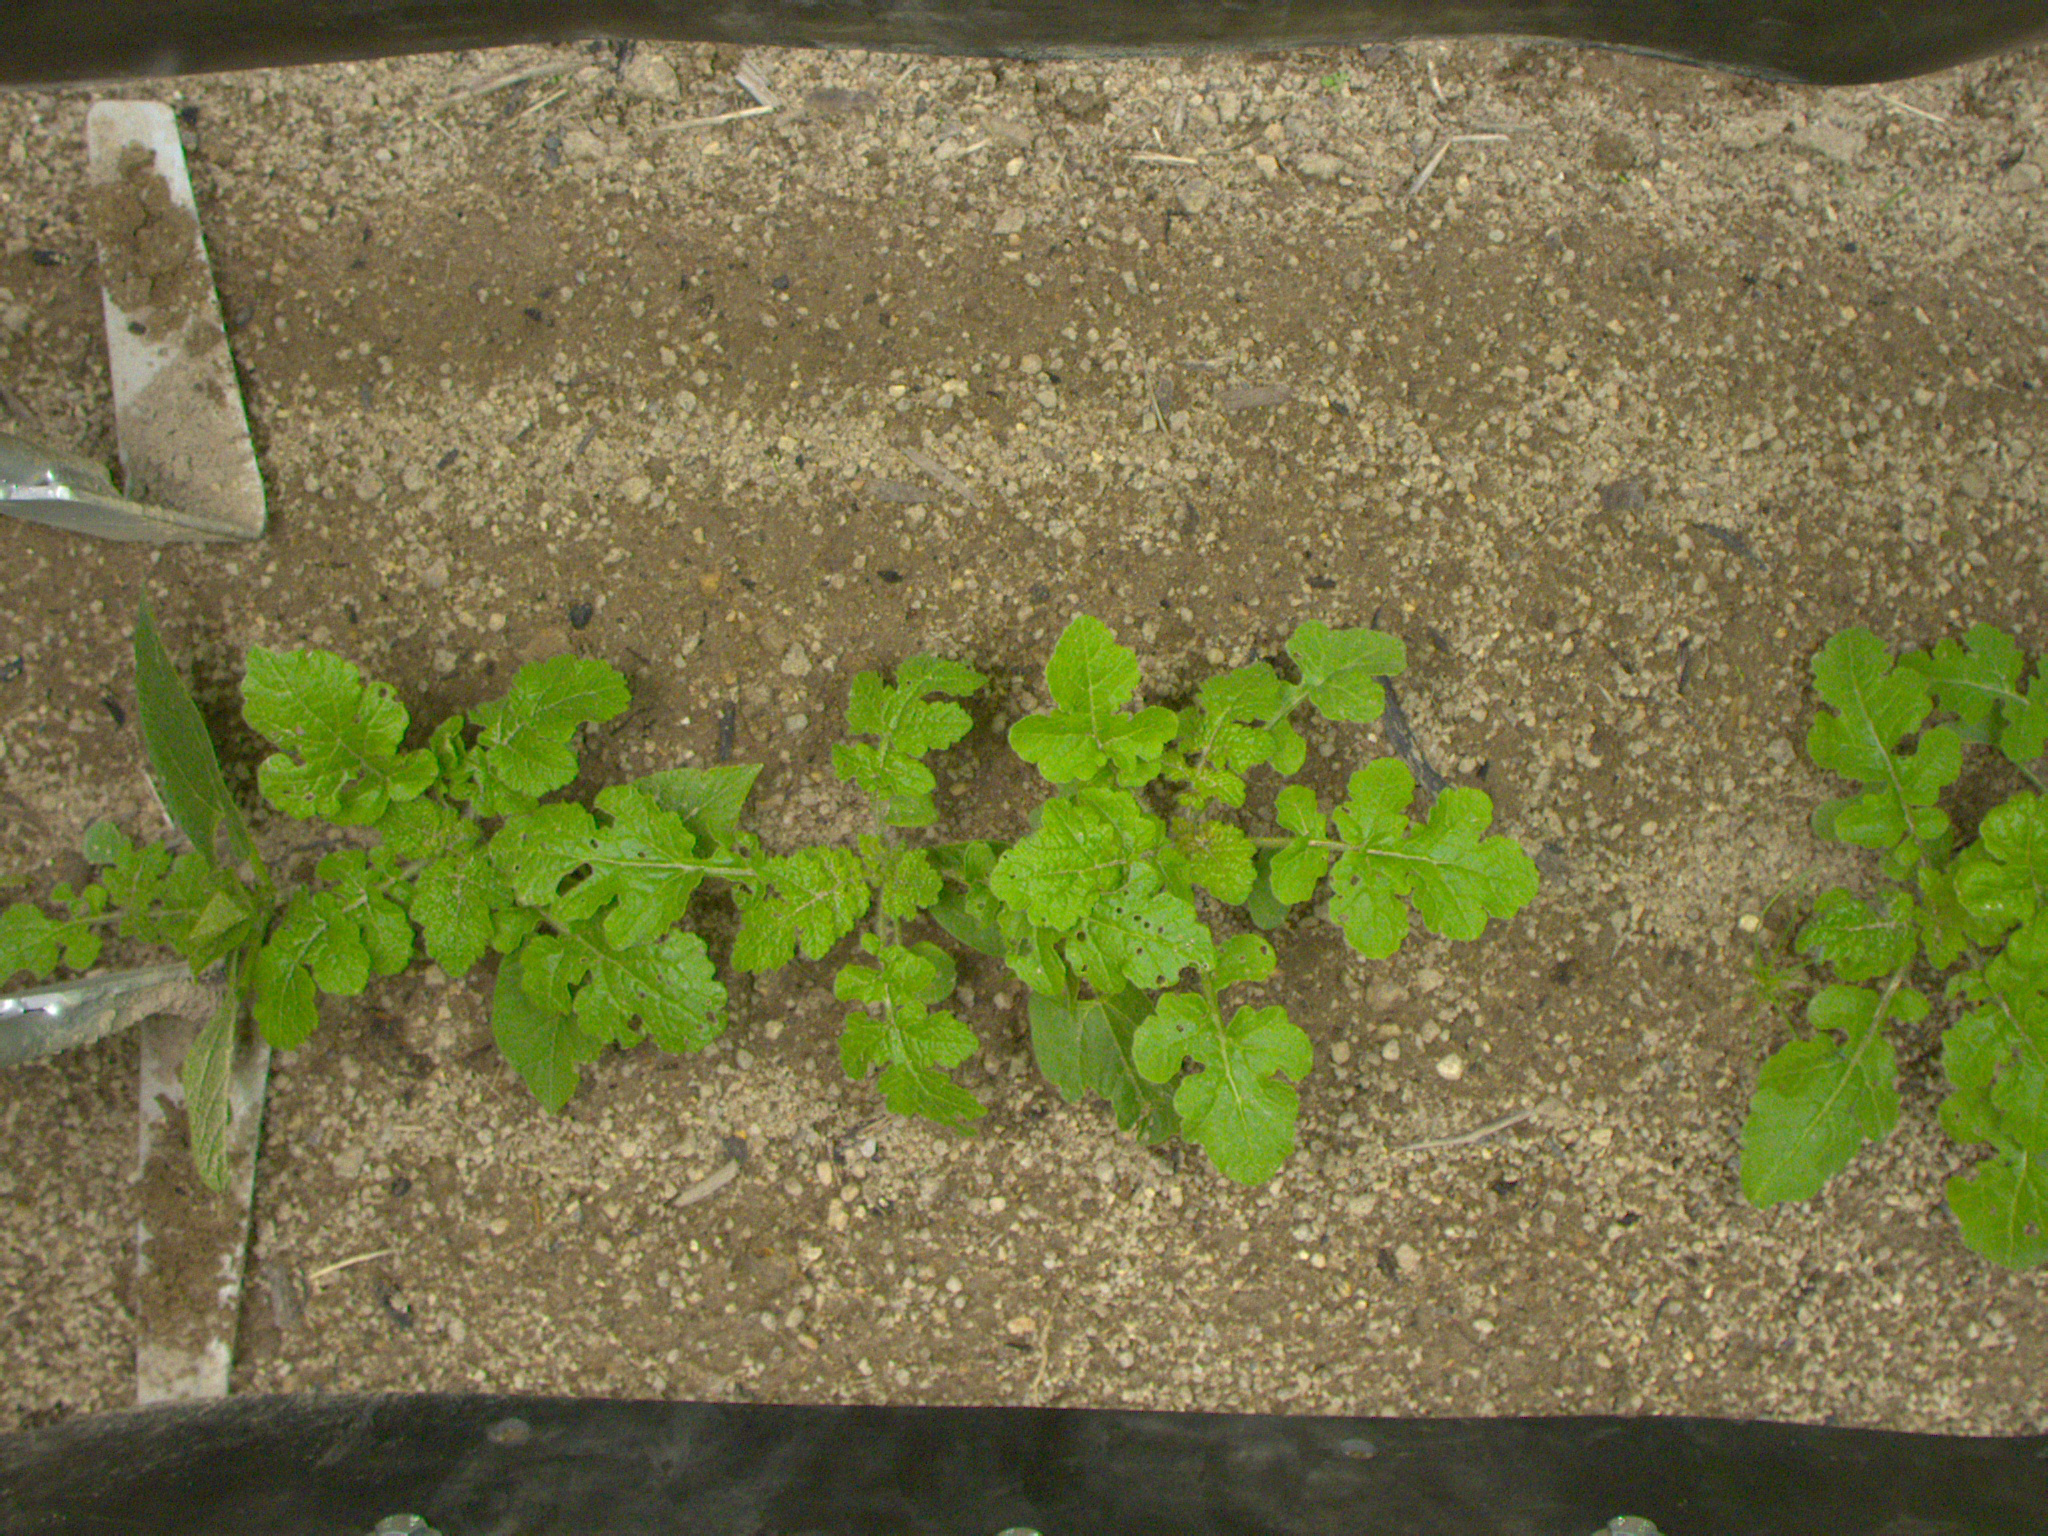

/content/Development_Dataset/Training/Bipbip/Haricot/Images/Bipbip_haricot_im_04541.jpg


In [12]:
import PIL
for image in training_images[:1]:
  PIL.Image.open(str(image))
  print(str(image))

In [13]:
import pathlib
path = os.path.join(cwd, 'Development_Dataset/Training/Bipbip/Haricot/Masks') 
data_dir = pathlib.Path(path)
training_masks = list(data_dir.glob('*'))
print(f"number of images: {len(training_images)}")

number of images: 180


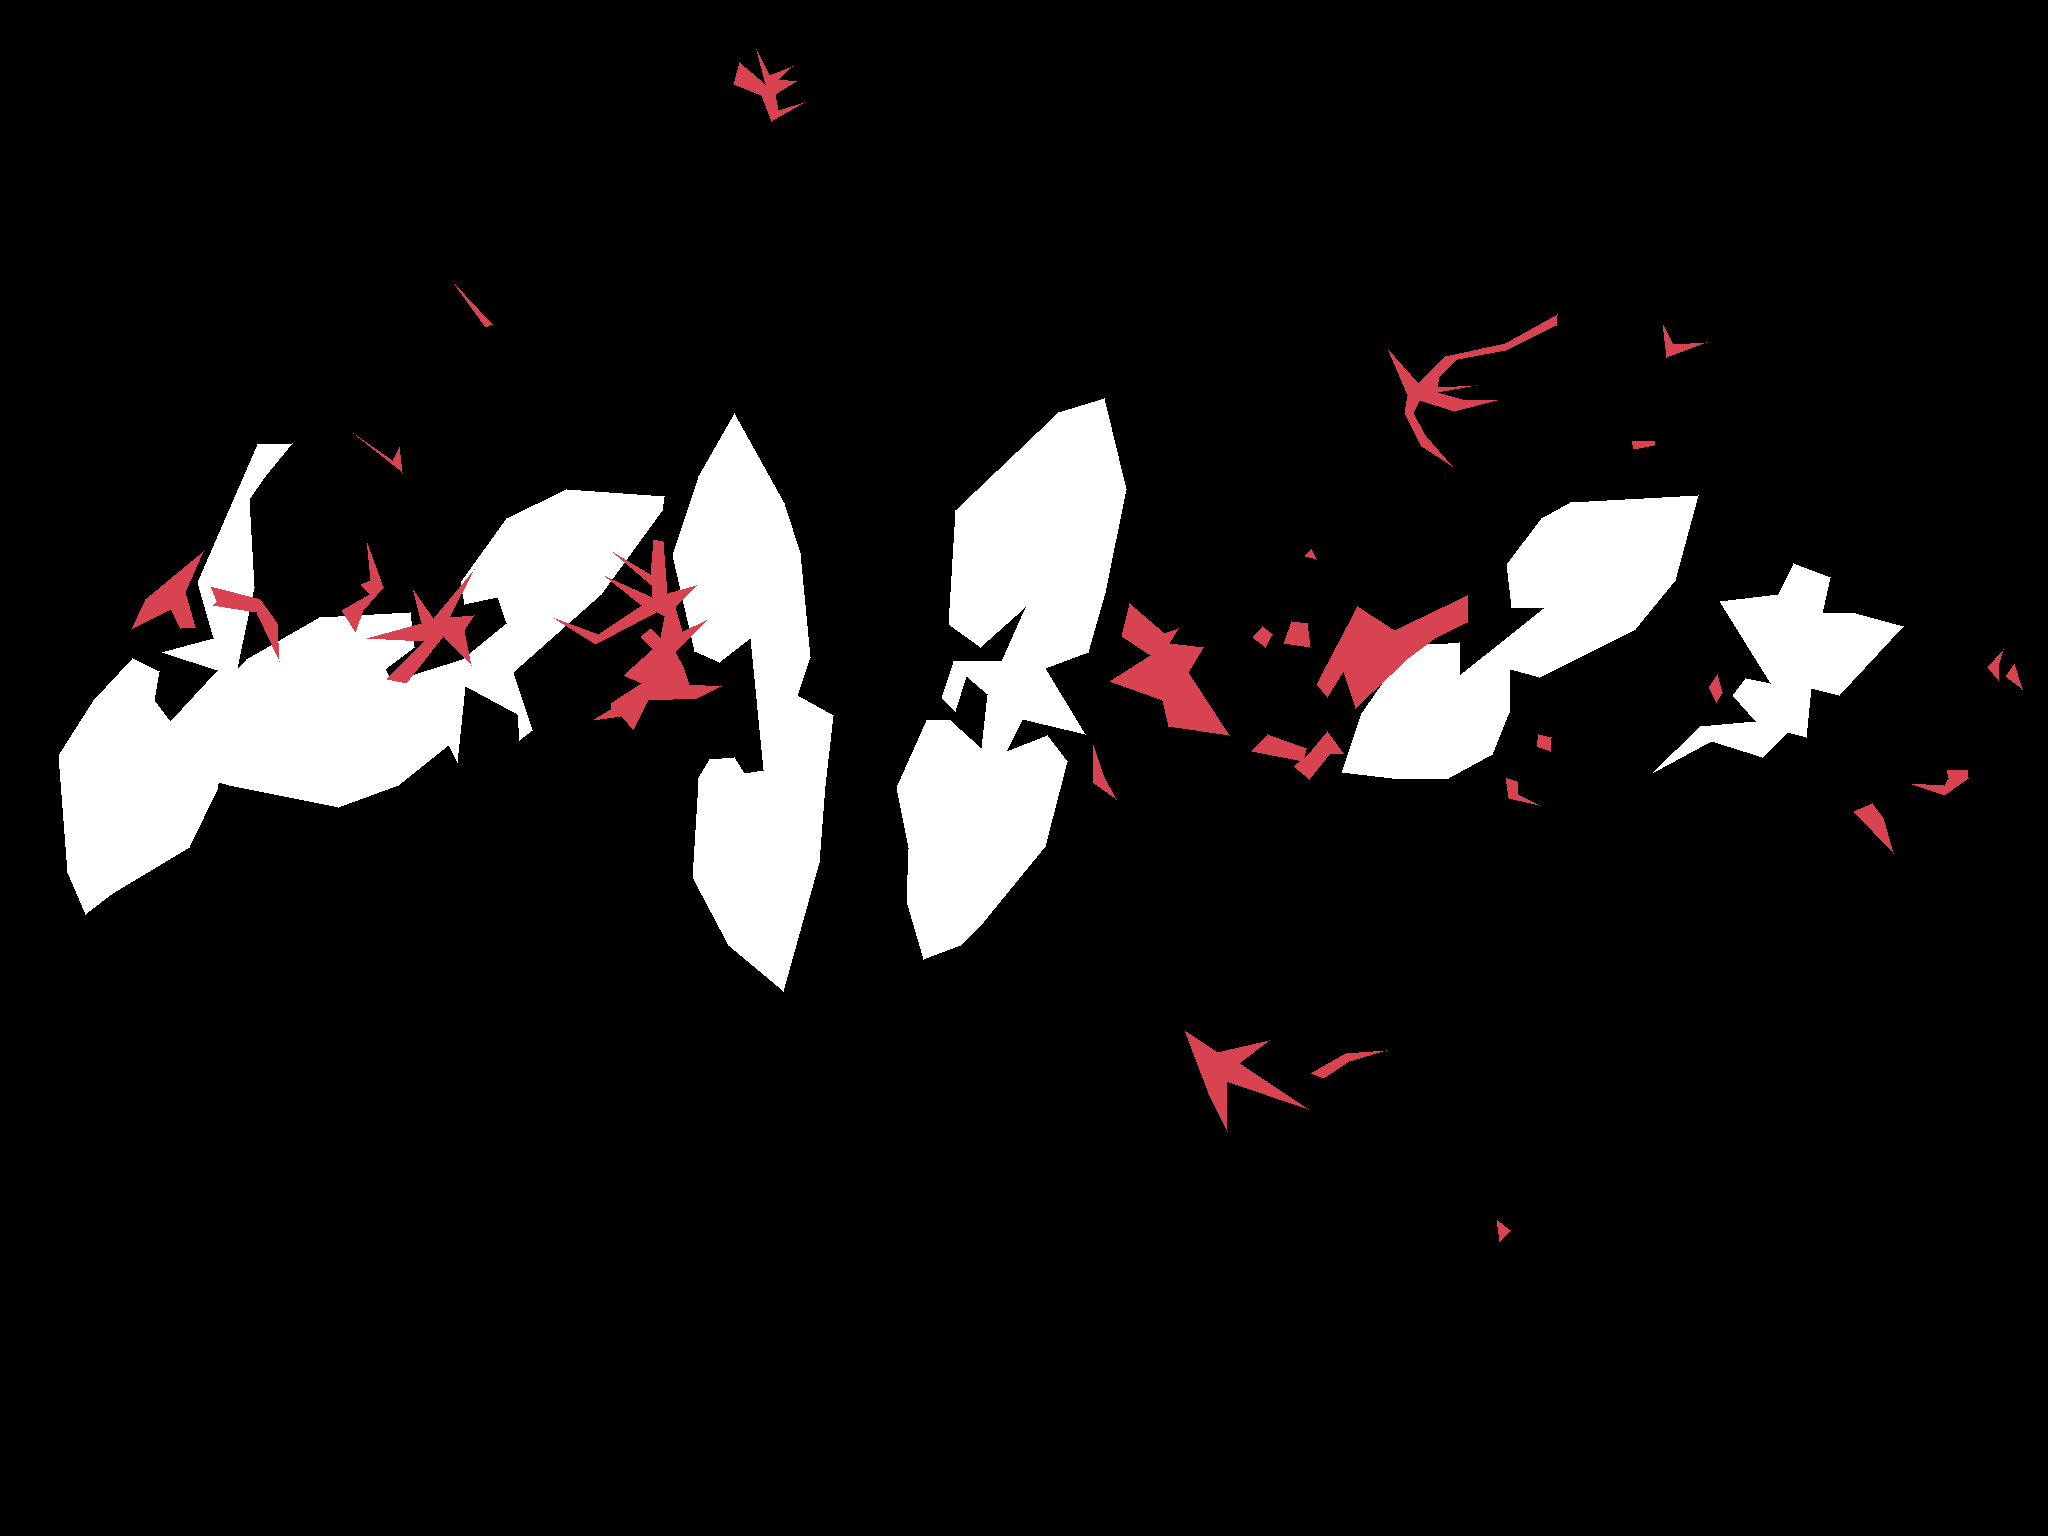

/content/Development_Dataset/Training/Bipbip/Haricot/Masks/Bipbip_haricot_im_00651.png


In [14]:
import PIL
for image in training_masks[:1]:
  PIL.Image.open(str(image))
  print(str(image))

# Example: Image Segmentation
## Build segmentation

In [15]:
# ImageDataGenerator
# ------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator

apply_data_augmentation = True

# Create training ImageDataGenerator object
# We need two different generators for images and corresponding masks
if apply_data_augmentation:
    img_data_gen = ImageDataGenerator(rotation_range=10,
                                      width_shift_range=10,
                                      height_shift_range=10,
                                      zoom_range=0.3,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      fill_mode='reflect')
    mask_data_gen = ImageDataGenerator(rotation_range=10,
                                       width_shift_range=10,
                                       height_shift_range=10,
                                       zoom_range=0.3,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       fill_mode='reflect')

In [16]:
import random
path_haricot = 'Development_Dataset/Training/Bipbip/Haricot/'
if not os.path.exists(path_haricot + '/Splits'):
  os.makedirs(path_haricot + '/Splits')
split_path_t = path_haricot + '/Splits/train.txt'
split_path_v = path_haricot + '/Splits/val.txt'

with open(split_path_t, 'w') as t:
  with open(split_path_v, 'w') as v:
    for image in training_images:
      if random.random() > VALIDATION_SPLIT:
        t.write(str(image).split('/')[-1].strip('.jpg')+'\n')
      else:
        v.write(str(image).split('/')[-1].strip('.jpg')+'\n')

24

24

21

24

24

21

24

24

21

24

21

21

24

24

21

21

24

24

24

21

24

24

21

21

21

24

21

21

21

21

24

21

21

24

24

21

21

24

21

24

21

21

24

24

24

21

21

24

24

21

24

21

24

21

21

24

24

21

24

24

21

21

21

24

24

21

21

24

24

24

21

24

21

21

21

21

21

21

21

24

24

21

24

21

24

21

24

24

21

24

21

24

24

21

24

21

24

24

21

21

21

24

24

21

24

24

21

21

24

21

21

24

21

24

21

24

21

21

24

24

24

24

21

24

21

24

21

24

21

21

24

24

21

21

24

24

24

21

21

21

21

24

21

21

21

24

21

24

21

21

24

24

24

24

24

24

21

21

21

24

21

24

21

24

21

21

24

21

21

21

24

24

21

24

24

24

24

24

21

24

In [17]:
path_mais = 'Development_Dataset/Training/Bipbip/Mais/'
if not os.path.exists(path_mais + '/Splits'):
  os.makedirs(path_mais + '/Splits')
split_path_t = path_mais + '/Splits/train.txt'
split_path_v = path_mais + '/Splits/val.txt'

with open(split_path_t, 'w') as t:
  with open(split_path_v, 'w') as v:
    for image in training_images:
      if random.random() > VALIDATION_SPLIT:
        t.write(str(image).split('/')[-1].strip('.jpg')+'\n')
      else:
        v.write(str(image).split('/')[-1].strip('.jpg')+'\n')

24

24

21

24

24

21

24

24

21

24

21

21

24

24

21

21

24

24

24

21

24

24

21

21

21

24

21

21

21

21

24

21

21

24

24

21

21

24

21

24

21

21

24

24

24

21

21

24

24

21

24

21

24

21

21

24

24

21

24

24

21

21

21

24

24

21

21

24

24

24

21

24

21

21

21

21

21

21

21

24

24

21

24

21

24

21

24

24

21

24

21

24

24

21

24

21

24

24

21

21

21

24

24

21

24

24

21

21

24

21

21

24

21

24

21

24

21

21

24

24

24

24

21

24

21

24

21

24

21

21

24

24

21

21

24

24

24

21

21

21

21

24

21

21

21

24

21

24

21

21

24

24

24

24

24

24

21

21

21

24

21

24

21

24

21

21

24

21

21

21

24

24

21

24

24

24

24

24

21

24

In [ ]:
from PIL import Image

class CustomDataset(tf.keras.utils.Sequence):

  """
    CustomDataset inheriting from tf.keras.utils.Sequence.

    3 main methods:
      - __init__: save dataset params like directory, filenames..
      - __len__: return the total number of samples in the dataset
      - __getitem__: return a sample from the dataset

    Note: 
      - the custom dataset return a single sample from the dataset. Then, we use 
        a tf.data.Dataset object to group samples into batches.
      - in this case we have a different structure of the dataset in memory. 
        We have all the images in the same folder and the training and validation splits
        are defined in text files.

  """

  def __init__(self, dataset_dir, which_subset, img_generator=None, mask_generator=None, 
               preprocessing_function=None, out_shape=[256, 256]):
    if which_subset == 'training':
      subset_file = os.path.join(dataset_dir, 'Splits', 'train.txt')
    elif which_subset == 'validation':
      subset_file = os.path.join(dataset_dir, 'Splits', 'val.txt')
    
    with open(subset_file, 'r') as f:
      lines = f.readlines()
    
    subset_filenames = []
    for line in lines:
      subset_filenames.append(line.strip()) 

    self.which_subset = which_subset
    self.dataset_dir = dataset_dir
    self.subset_filenames = subset_filenames
    self.img_generator = img_generator
    self.mask_generator = mask_generator
    self.preprocessing_function = preprocessing_function
    self.out_shape = out_shape

  def __len__(self):
    return len(self.subset_filenames)

  def __getitem__(self, index):
    # Read Image
    curr_filename = self.subset_filenames[index]
    img = Image.open(os.path.join(self.dataset_dir, 'Images', curr_filename + '.jpg'))
    mask = Image.open(os.path.join(self.dataset_dir, 'Masks', curr_filename + '.png'))

    # Resize image and mask
    img = img.resize(self.out_shape)
    mask = mask.resize(self.out_shape, resample=Image.NEAREST)
    
    img_arr = np.array(img)
    mask_arr = np.array(mask)

    # in this dataset 255 mask label is assigned to an additional class, which corresponds 
    # to the contours of the objects. We remove it for simplicity.
    mask_arr[mask_arr == 255] = 0  

    mask_arr = np.expand_dims(mask_arr, -1)

    if self.which_subset == 'training':
      if self.img_generator is not None and self.mask_generator is not None:
        # Perform data augmentation
        # We can get a random transformation from the ImageDataGenerator using get_random_transform
        # and we can apply it to the image using apply_transform
        img_t = self.img_generator.get_random_transform(img_arr.shape, seed=SEED)
        mask_t = self.mask_generator.get_random_transform(mask_arr.shape, seed=SEED)
        img_arr = self.img_generator.apply_transform(img_arr, img_t)
        # ImageDataGenerator use bilinear interpolation for augmenting the images.
        # Thus, when applied to the masks it will output 'interpolated classes', which
        # is an unwanted behaviour. As a trick, we can transform each class mask 
        # separately and then we can cast to integer values (as in the binary segmentation notebook).
        # Finally, we merge the augmented binary masks to obtain the final segmentation mask.
        out_mask = np.zeros_like(mask_arr)
        for c in np.unique(mask_arr):
          if c > 0:
            curr_class_arr = np.float32(mask_arr == c)
            curr_class_arr = self.mask_generator.apply_transform(curr_class_arr, mask_t)
            # from [0, 1] to {0, 1}
            curr_class_arr = np.uint8(curr_class_arr)
            # recover original class
            curr_class_arr = curr_class_arr * c 
            out_mask += curr_class_arr
    else:
      out_mask = mask_arr
    
    if self.preprocessing_function is not None:
        img_arr = self.preprocessing_function(img_arr)

    return img_arr, np.float32(out_mask)

In [ ]:
!ls Development_Dataset/Training/Bipbip/Haricot/

Images	Masks


In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input 

img_h = 256
img_w = 256

dataset = CustomDataset('/content/Development_Dataset/Training/Bipbip/Haricot/', 'training', 
                        img_generator=img_data_gen, mask_generator=mask_data_gen,
                        preprocessing_function=preprocess_input)
dataset_valid = CustomDataset('/content/Development_Dataset/Training/Bipbip/Haricot/', 'validation', 
                              preprocessing_function=preprocess_input)


In [ ]:

train_dataset = tf.data.Dataset.from_generator(lambda: dataset,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))

train_dataset = train_dataset.batch(32)

train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: dataset_valid,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))
valid_dataset = valid_dataset.batch(32)

valid_dataset = valid_dataset.repeat()

In [ ]:
!ls /content/VOCDataset

Annotations  Images  Splits


In [ ]:
# Let's test data generator
# -------------------------
import time
from matplotlib import cm
import matplotlib.pyplot as plt

%matplotlib inline

# Assign a color to each class
evenly_spaced_interval = np.linspace(0, 1, 3)
colors = [cm.rainbow(x) for x in evenly_spaced_interval]

iterator = iter(valid_dataset)

InvalidArgumentError: ignored

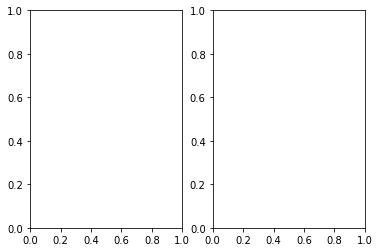

In [ ]:
fig, ax = plt.subplots(1, 2)

augmented_img, target = next(iterator)
augmented_img = augmented_img[0]   # First element
augmented_img = augmented_img  # denormalize

target = np.array(target[0, ..., 0])   # First element (squeezing channel dimension)

print(np.unique(target))

target_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
for i in range(1, 21):
  target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

ax[0].imshow(np.uint8(augmented_img))
ax[1].imshow(np.uint8(target_img))

plt.show()

In [ ]:
vgg = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))
vgg.summary()
for layer in vgg.layers:
  layer.trainable = False

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
______________________________________________________________

## Convolutional Neural Network (CNN)
### Encoder-Decoder

In [ ]:
def create_model(depth, start_f, num_classes):

    model = tf.keras.Sequential()
    
    # Encoder
    # -------
    model.add(vgg)
    
    start_f = 256
        
    # Decoder
    # -------
    for i in range(depth):
        model.add(tf.keras.layers.UpSampling2D(2, interpolation='bilinear'))
        model.add(tf.keras.layers.Conv2D(filters=start_f,
                                         kernel_size=(3, 3),
                                         strides=(1, 1),
                                         padding='same'))
        model.add(tf.keras.layers.ReLU())

        start_f = start_f // 2

    # Prediction Layer
    # ----------------
    model.add(tf.keras.layers.Conv2D(filters=num_classes,
                                     kernel_size=(1, 1),
                                     strides=(1, 1),
                                     padding='same',
                                     activation='softmax'))
    
    return model

In [ ]:
model = create_model(depth=5, 
                     start_f=8, 
                     num_classes=21)

# Visualize created model as a table
model.summary()

# Visualize initialized weights
# model.weights

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 16, 16, 512)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 256)       1179904   
_________________________________________________________________
re_lu (ReLU)                 (None, 16, 16, 256)       0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       295040    
_________________________________________________________________
re_lu_1 (ReLU)               (None, 32, 32, 128)       0

## Prepare the model for training

In [ ]:
# Optimization params
# -------------------

# Loss
# Sparse Categorical Crossentropy to use integers (mask) instead of one-hot encoded labels
loss = tf.keras.losses.SparseCategoricalCrossentropy() 
# learning rate
lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

# Here we define the intersection over union for each class in the batch.
# Then we compute the final iou as the mean over classes
def meanIoU(y_true, y_pred):
    # get predicted class from softmax
    y_pred = tf.expand_dims(tf.argmax(y_pred, -1), -1)

    per_class_iou = []

    for i in range(1,21): # exclude the background class 0
      # Get prediction and target related to only a single class (i)
      class_pred = tf.cast(tf.where(y_pred == i, 1, 0), tf.float32)
      class_true = tf.cast(tf.where(y_true == i, 1, 0), tf.float32)
      intersection = tf.reduce_sum(class_true * class_pred)
      union = tf.reduce_sum(class_true) + tf.reduce_sum(class_pred) - intersection
    
      iou = (intersection + 1e-7) / (union + 1e-7)
      per_class_iou.append(iou)

    return tf.reduce_mean(per_class_iou)

# Validation metrics
# ------------------
metrics = ['accuracy', meanIoU]
# ------------------

# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

## Training with callbacks

In [ ]:
import os
from datetime import datetime

cwd = os.getcwd()

exps_dir = os.path.join(cwd, 'drive/My Drive/Keras4/', 'multiclass_segmentation_experiments')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'CNN'

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                   save_weights_only=True)  # False to save the model directly
callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=0)  # if 1 shows weights histograms
callbacks.append(tb_callback)

# Early Stopping
# --------------
early_stop = False
if early_stop:
    es_callback = tf.keras.callback.EarlyStopping(monitor='val_loss', patience=10)
    callbacks.append(es_callback)


model.fit(x=train_dataset,
          epochs=100,  #### set repeat in training dataset
          steps_per_epoch=len(dataset),
          validation_data=valid_dataset,
          validation_steps=len(dataset_valid), 
          callbacks=callbacks)

# How to visualize Tensorboard

# 1. tensorboard --logdir EXPERIMENTS_DIR --port PORT     <- from terminal
# 2. localhost:PORT   <- in your browser

Epoch 1/100
209/209 [==============================] - 341s 2s/step - loss: 0.8953 - accuracy: 0.7965 - meanIoU: 0.1102 - val_loss: 1.7275 - val_accuracy: 0.7824 - val_meanIoU: 0.1481
Epoch 2/100
209/209 [==============================] - 341s 2s/step - loss: 0.3382 - accuracy: 0.8846 - meanIoU: 0.3083 - val_loss: 2.2178 - val_accuracy: 0.7727 - val_meanIoU: 0.1158
Epoch 3/100
209/209 [==============================] - 340s 2s/step - loss: 0.1840 - accuracy: 0.9338 - meanIoU: 0.5332 - val_loss: 2.3657 - val_accuracy: 0.7781 - val_meanIoU: 0.0951
Epoch 4/100
209/209 [==============================] - 344s 2s/step - loss: 0.1423 - accuracy: 0.9451 - meanIoU: 0.6009 - val_loss: 2.4710 - val_accuracy: 0.7716 - val_meanIoU: 0.1153
Epoch 5/100
209/209 [==============================] - 343s 2s/step - loss: 0.1268 - accuracy: 0.9495 - meanIoU: 0.6344 - val_loss: 2.4702 - val_accuracy: 0.7784 - val_meanIoU: 0.1003
Epoch 6/100
209/209 [==============================] - 342s 2s/step - loss: 0.11

KeyboardInterrupt: ignored

## Test model

## Compute prediction

In [ ]:
model.load_weights('/content/drive/My Drive/Keras4/multiclass_segmentation_experiments/CNN_Dec08_13-44-03/ckpts/cp_02.ckpt')

In [ ]:
import time
import matplotlib.pyplot as plt

from PIL import Image

%matplotlib inline

iterator = iter(valid_dataset)

(1, 256, 256, 21)

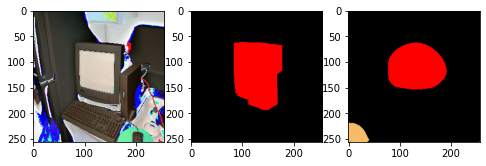

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(8, 8))
fig.show()
image, target = next(iterator)

image = image[0]
target = target[0, ..., 0]

out_sigmoid = model.predict(x=tf.expand_dims(image, 0))

# Get predicted class as the index corresponding to the maximum value in the vector probability
# predicted_class = tf.cast(out_sigmoid > score_th, tf.int32)
# predicted_class = predicted_class[0, ..., 0]
predicted_class = tf.argmax(out_sigmoid, -1)

out_sigmoid.shape

predicted_class = predicted_class[0, ...]

# Assign colors (just for visualization)
target_img = np.zeros([target.shape[0], target.shape[1], 3])
prediction_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
for i in range(1, 21):
  target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

prediction_img[np.where(predicted_class == 0)] = [0, 0, 0]
for i in range(1, 21):
  prediction_img[np.where(predicted_class == i)] = np.array(colors[i-1])[:3] * 255

ax[0].imshow(np.uint8(image))
ax[1].imshow(np.uint8(target_img))
ax[2].imshow(np.uint8(prediction_img))

fig.canvas.draw()
time.sleep(1)